## Temperature Tendency Analysis

Here, I analyse a simulation where I hacked the Isca code, so it output useful tendency information.

Some diagnostics are different for this simulation. All have units of *K/s*:
* `dt_vg_diffusion`: Total temperature tendency before any diffusion calculation (basically just `dt_tg_convection` + `tdt_rad`).
* `dt_ug_diffusion`: Total temperature tendency after downward diffusion, but before upward diffusion. This is very similar to the above tendency as downward diffusion does not have much effect.
* `dt_tg_diffusion`: Total temperature tendency after all diffusion calculations. This differs near the surface to the above.
* `ucomp`: Total temperature tendency after both horizontal and vertical advection.
* `vcomp`: Total temperature tendency after the leapfrog procedure. I.e. this is `(temp(future)-temp(current))/time_step`.
* `omega`: Vertical advection temperature tendency.

In addition, I changed `delta_t_surf` so units are *K/s* rather than *K*, for ease of comparison. But still gives temperature tendency of the surface.

In [20]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [21]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
# save_suffix = '.pdf'          # if for paper
save_suffix = '.jpg'
dpi = {'.pdf': 800, '.jpg': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [85]:
exp_dir = 'play/temp_tendency/'
tau_lw_ref = 1
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}_taubm=2000", f"k={str(tau_lw_ref).replace('.','_')}", 
             f"k={str(tau_lw_ref).replace('.','_')}_taubm=72000"]
# exp_names = [f"k=3_5_no_diffusion", f"k={str(tau_lw_ref).replace('.','_')}", f"k=3_5_no_diffusion_taubm=2000"]
exp_names = [f"k=3_5_radtime=0_6", f"k=3_5_radtime=0_8"]
# exp_names = [f"k=3_5", f"k=3_5_taubm=2000"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []
conv_timescale = []

use_time_start = 360*2
# use_time_start = 0      # because little data
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf))]      # only keep after spin up
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    try:
        conv_timescale += [namelist['qe_moist_convection_nml']['tau_bm']]
    except KeyError:
        conv_timescale += [7200]        # default value
# conv_timescale = ['$\kappa=3.5$ no diffusion (7200)', '$\kappa=3.5$ (7200)', '$\kappa=3.5$ no diffusion (2000)']

In [86]:
conv_timescale = ['$\kappa=3.5$ (0.6)', '$\kappa=3.5$ (0.8)']
# conv_timescale = ['$\kappa=3.5$ (7200)', '$\kappa=3.5$ (2000)']

In [87]:
# Load in dataset with surface and free troposphere across all latitudes, for given season
pressure_ft = 500

# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40  # should be 40, but saving memory
lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 80
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

# Chose whether to only consider summer days for mean or all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH 
if region == 'tropics':
    use_summer = False      # if true, will set ds will only contain summer months. Do this outside tropics
elif region == 'extratropics':
    use_summer = True

ds = []  # need both all and summer day dataset
lat_use_ind = np.where((np.abs(ds_base[0].lat) <= lat_max) & (np.abs(ds_base[0].lat) >= lat_min))[0]
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds_base[i].sel(pfull=[np.inf, pressure_ft], method='nearest')
        if use_summer:
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds += [ds_use.isel(lat=lat_use_ind).load()]
        pbar.update(1)
n_lat = ds[0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds[0].lat))     # latitude area weighting is just the cosine
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft] * 100)
n_pressure = 2

100%|██████████| 2/2 [00:23<00:00, 11.74s/it]


In [88]:
# Get values averaged around a surface temperature percentile, rather than exactly on it.
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)

# Only include vertical advection if all experiments have it, otherwise just plot total advection
include_vert_advection = np.all(['omega' in ds[i] for i in range(n_exp)])

# Note the quant3_type doesn't make much difference and only really makes a difference in the tropics
# where the equivalence of the temperature and moist static energy percentiles is not as valid.
quant3_method = 'temp'            # Take percentile to be temperature percentile      (this is legacy, what I was doing previously)
# quant3_method = 'mse'             # Take percentile to be of near-surface mse (think this is correct version of theory)
percentile_label = 'Temperature percentile, $x$' if quant3_method == 'temp' else 'MSE percentile, $x$'
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant)) 
temp_mean = np.zeros((n_exp, n_pressure, n_lat))   
# In free troposphere, this is saturated MSE.
mse_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant))  
mse_mean = np.zeros((n_exp, n_pressure, n_lat))
sphum_quant3 = np.zeros((n_exp, n_lat, n_quant))
z_quant3 = np.zeros((n_exp, n_lat, n_quant))
temp_tend_quant3 = {'convection': np.zeros((n_exp, n_pressure, n_lat, n_quant)), 
                    'radiation': np.zeros((n_exp, n_pressure, n_lat, n_quant)),
                    'diffusion': np.zeros((n_exp, n_pressure, n_lat, n_quant)),
                    'advection_horizontal': np.zeros((n_exp, n_pressure, n_lat, n_quant))}
if include_vert_advection:
    temp_tend_quant3['advection_vertical'] = np.zeros((n_exp, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant))
klzb_quant3 = np.zeros((n_exp, n_lat, n_quant))
cape_quant3 = np.zeros((n_exp, n_lat, n_quant))
temp_surf_diff_quant3 = np.zeros((n_exp, n_lat, n_quant))
temp_convref_diff_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant))
epsilon_convref_quant3 = np.zeros((n_exp, n_lat, n_quant))
with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse = moist_static_energy(ds[i].temp[ind_surf], ds[i].sphum[ind_surf], ds[i].height[ind_surf])
        mse_ft = moist_static_energy(ds[i].temp[ind_ft], sphum_sat(ds[i].temp[ind_ft], pressure_ft_actual), ds[i].height[ind_ft])
        epsilon_convref = moist_static_energy(
            ds[i].t_ref[ind_surf], ds[i].sphum[ind_surf], ds[i].height[ind_surf]) - moist_static_energy(
            ds[i].t_ref[ind_ft], sphum_sat(ds[i].t_ref[ind_ft], pressure_ft_actual), ds[i].height[ind_ft])
        mse_mean[i, 0] = mse.mean(dim='lon_time')
        mse_mean[i, 1] = mse_ft.mean(dim='lon_time')
        temp_mean[i] = ds[i].temp.mean(dim='lon_time')
        is_convecting = np.logical_and(ds[i].klzbs<=13, ds[i].convflag > 1)
        for k in range(n_lat):
            for j, quant in enumerate(quant_plot):
                if quant3_method == 'temp':
                    use_ind = get_quant_ind(ds[i].temp[0, k], quant, 0.5, 0.5)
                elif quant3_method == 'mse':
                    use_ind = get_quant_ind(mse[k], quant, 0.5, 0.5)
                else:
                    raise ValueError('quant3_type not valid')
                temp_quant3[i, :, k, j] = ds[i].temp[:, k, use_ind].mean(dim='lon_time')
                mse_quant3[i, 0, k, j] = mse[k, use_ind].mean(dim='lon_time')           # this is the same as mse_quant2 if quant3_type == mse
                mse_quant3[i, 1, k, j] = mse_ft[k, use_ind].mean(dim='lon_time')
                sphum_quant3[i, k, j] = ds[i].sphum[ind_surf, k, use_ind].mean(dim='lon_time')   
                z_quant3[i, k, j] = ds[i].height[ind_ft, k, use_ind].mean(dim='lon_time')
                convflag_quant3[i, k, j] = ds[i].convflag[k, use_ind].mean(dim='lon_time', skipna=True)
                klzb_quant3[i, k, j] = ds[i].klzbs[k, use_ind].mean(dim='lon_time', skipna=True)
                cape_quant3[i, k, j] = ds[i].cape[k, use_ind].mean(dim='lon_time', skipna=True)
                temp_surf_diff_quant3[i, k, j] = (ds[i].t_surf - 
                                                  ds[i].temp.isel(pfull=ind_surf))[k, use_ind].mean(dim='lon_time', skipna=True)
                temp_convref_diff_quant3[i, :, k, j] = (ds[i].t_ref - ds[i].temp).where(is_convecting)[:, k, use_ind].mean(
                    dim='lon_time', skipna=True)
                epsilon_convref_quant3[i, k, j] = epsilon_convref.where(is_convecting)[k, use_ind].mean(
                    dim='lon_time', skipna=True)
                temp_tend_quant3['convection'][i, :, k, j] = ds[i].dt_tg_convection[:, k, use_ind].mean(dim='lon_time', skipna=True)
                temp_tend_quant3['radiation'][i, :, k, j] = ds[i].tdt_rad[:, k, use_ind].mean(dim='lon_time', skipna=True)
                temp_tend_quant3['diffusion'][i, :, k, j] = (ds[i].dt_tg_diffusion - 
                                                             ds[i].dt_vg_diffusion)[:, k, use_ind].mean(dim='lon_time', skipna=True)
                if include_vert_advection:
                    temp_tend_quant3['advection_horizontal'][i, :, k, j] = (ds[i].ucomp - 
                                                                 ds[i].dt_tg_diffusion-ds[i].omega)[:, k, use_ind].mean(dim='lon_time', skipna=True)
                    temp_tend_quant3['advection_vertical'][i, :, k, j] = ds[i].omega[:, k, use_ind].mean(dim='lon_time', skipna=True)
                else:
                    # Just record total advection if no vertical info
                    temp_tend_quant3['advection_horizontal'][i, :, k, j] = (ds[i].ucomp - 
                                             ds[i].dt_tg_diffusion)[:, k, use_ind].mean(dim='lon_time', skipna=True)
                pbar.update(1)

100%|██████████| 3564/3564 [01:05<00:00, 54.42it/s]


In [89]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds_base[0].pfull)), ds_base[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

### Convective Details
Plot `convflag` (whether deep or shallow convection), level of neutral buoyancy and CAPE as a function of quantile for each simulation to see how convection varies with temperature.

In [90]:
# x_var = [quant_plot for i in range(n_exp)]
# x_var_name = percentile_label
# x_lim = [0, 100]
x_var = [np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights) for i in range(n_exp)]
x_var_name = 'Near-surface temperature [K]'
x_lim = [np.asarray(x_var).min(), np.asarray(x_var).max()]

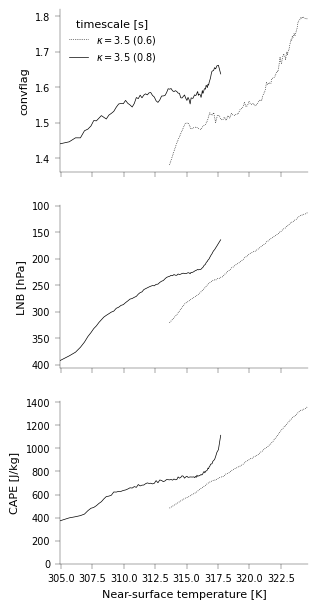

In [91]:
linestyles = [':', '-', '--']

save_convflag_fig = True
fig, ax = plt.subplots(3,1, figsize=(width['one_col'], 3*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(x_var[i], np.average(convflag_quant3[i], axis=0, weights=lat_weights),
            color='k', linestyle=linestyles[i], label=conv_timescale[i])
    ax[1].plot(x_var[i], lzb(np.average(klzb_quant3[i], axis=0, weights=lat_weights)),
            color='k', linestyle=linestyles[i])
    ax[2].plot(x_var[i], np.average(cape_quant3[i], axis=0, weights=lat_weights),
               color='k', linestyle=linestyles[i])
ax[1].invert_yaxis()
ax[-1].set_xlabel(x_var_name)
ax[0].set_ylabel('convflag')
ax[1].set_ylabel('LNB [hPa]')
ax[2].set_ylabel('CAPE [J/kg]')
ax[0].legend(title='timescale [s]')
ax[0].set_xlim(x_lim)
ax[-1].set_ylim(0, ax[-1].get_ylim()[1])

if save_fig or save_convflag_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convflag_{region}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Temperature Tendencies
Plot the different contributions to the temperature tendency at the surface and free troposphere.

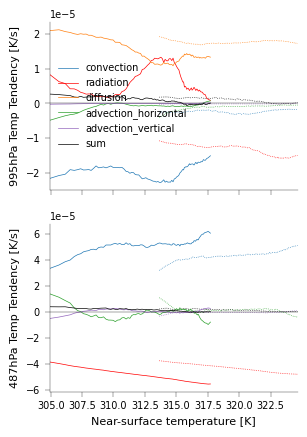

In [92]:
colors_tend = {'convection': default_colors[0], 'radiation': 'r', 'diffusion': default_colors[1], 
               'advection_horizontal': default_colors[2], 'advection_vertical': default_colors[4]}
save_temp_tend_quant_fig = True
if save_temp_tend_quant_fig:
    fig, ax = plt.subplots(n_pressure, 1, figsize=(width['one_col'], n_pressure*width['one_col']/ar), sharex=True)
else:
    fig, ax = plt.subplots(n_pressure, 1, figsize=(10,8), sharex=True)
for i in range(n_exp):
    for j in range(n_pressure):
        ax[j].set_ylabel(f'{int(round(float(ds[0].pfull[j]), 0))}hPa Temp Tendency [K/s]')
        for key in temp_tend_quant3:
            if key == 'diffusion' and j==ind_ft:
                continue
            ax[j].plot(x_var[i], np.average(temp_tend_quant3[key][i, j], axis=0, weights=lat_weights),
                       color=colors_tend[key], label=key if i==1 else None, linestyle=linestyles[i])
        ax[j].plot(x_var[i], np.average(np.sum(np.asarray([temp_tend_quant3[key][i, j] for key in temp_tend_quant3]), axis=0),  
                                          axis=0, weights=lat_weights), 
                   color='k', label='sum' if i==1 else None, linestyle=linestyles[i])
ax[0].legend()
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[-1].set_xlabel(x_var_name)
# fig.supylabel('Temperature tendency [K/s]', fontsize=7)
# ax[0].set_title('Near-surface')
ax[0].set_xlim(x_lim)
if save_fig or save_temp_tend_quant_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_tend_quant_{region}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### MSE Difference
See how MSE differs between surface and free troposphere as function of near-surface temperature percentile. Would expect them to be equal if convection is setting temperature profile.

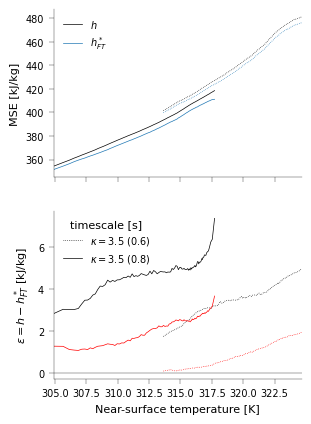

In [93]:
save_mse_diff_fig = True
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(x_var[i], 
               np.average(mse_quant3[i, ind_surf], axis=0, weights=lat_weights),
               color='k', linestyle=linestyles[i], label='$h$' if i==1 else None)
    ax[0].plot(x_var[i], 
               np.average(mse_quant3[i, ind_ft], axis=0, weights=lat_weights),
               color=default_colors[0], linestyle=linestyles[i], label='$h_{FT}^*$' if i==1 else None)
    ax[1].plot(x_var[i], np.average(mse_quant3[i, ind_surf] - mse_quant3[i, ind_ft], axis=0, weights=lat_weights),
               color='k', linestyle=linestyles[i], label=conv_timescale[i])
    ax[1].plot(x_var[i], np.average(epsilon_convref_quant3[i], axis=0, weights=lat_weights),
               color='r', linestyle=linestyles[i])
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].legend()
ax[1].legend(title='timescale [s]')
ax[1].set_xlabel(x_var_name)
ax[0].set_xlim(x_lim)
ax[0].set_ylabel('MSE [kJ/kg]')
ax[1].set_ylabel('$\epsilon = h-h^*_{FT}$ [kJ/kg]')
if save_fig or save_mse_diff_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_diff_conv_timescale_{region.lower()}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

### Breakdown of MSE
Below, I plot how MSE is broken down into temperature, specific humidity and geopotential height.

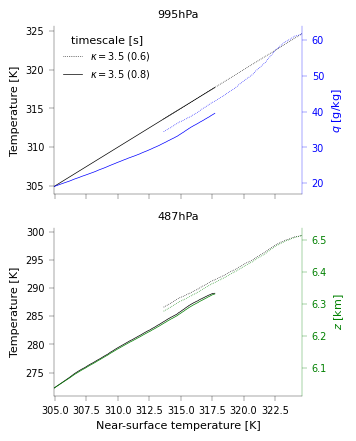

In [94]:
save_mse_breakdown_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
ax2 = ax[0].twinx()
ax2.spines[['bottom', 'left']].set_visible(False)
ax2.spines[['right']].set_visible(True)
ax2.tick_params(axis='y', colors='b')
ax2.spines['right'].set_color('b')
ax2.set_ylabel('$q$ [g/kg]', color='b')
ax3 = ax[1].twinx()
ax3.spines[['bottom', 'left']].set_visible(False)
ax3.spines[['right']].set_visible(True)
ax3.tick_params(axis='y', colors='g')
ax3.spines['right'].set_color('g')
ax3.set_ylabel('$z$ [km]', color='g')
ax[0].set_ylabel('Temperature [K]')
ax[1].set_ylabel('Temperature [K]')
ax[1].set_xlabel(x_var_name)
ax[0].set_xlim(x_lim)
ax[0].set_title(f'{int(round(float(ds[0].pfull[ind_surf]), 0))}hPa')
ax[1].set_title(f'{int(round(float(ds[0].pfull[ind_ft]), 0))}hPa')
for i in range(n_exp):
        ax[0].plot(x_var[i], 
               np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights),
               color='k', linestyle=linestyles[i], label=conv_timescale[i])
        ax2.plot(x_var[i], 
               np.average(sphum_quant3[i]*1000, axis=0, weights=lat_weights),
               color='b', linestyle=linestyles[i])
        ax[1].plot(x_var[i], 
               np.average(temp_quant3[i, ind_ft], axis=0, weights=lat_weights),
               color='k', linestyle=linestyles[i])
        ax3.plot(x_var[i], 
               np.average(z_quant3[i]/1000, axis=0, weights=lat_weights),
               color='g', linestyle=linestyles[i])
ax[0].legend(title='timescale [s]')
if save_fig or save_mse_breakdown_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_breakdown_conv_timescale_{region.lower()}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

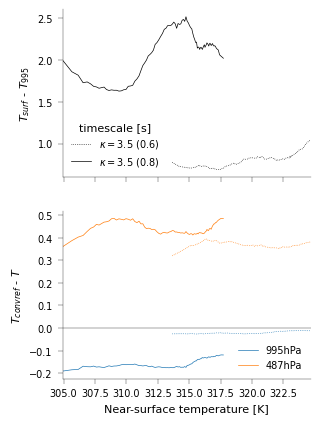

In [95]:
save_temp_surf_diff_fig = False
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(x_var[i], 
       np.average(temp_surf_diff_quant3[i], axis=0, weights=lat_weights),
       color='k', linestyle=linestyles[i], label=conv_timescale[i])
    ax[1].plot(x_var[i], 
       np.average(temp_convref_diff_quant3[i, ind_surf], axis=0, weights=lat_weights),
       color=default_colors[0], linestyle=linestyles[i], label='995hPa' if i==1 else None)
    ax[1].plot(x_var[i], 
       np.average(temp_convref_diff_quant3[i, ind_ft], axis=0, weights=lat_weights),
       color=default_colors[1], linestyle=linestyles[i], label='487hPa' if i==1 else None)
ax[0].legend(title='timescale [s]')
ax[1].legend()
ax[1].set_xlabel(x_var_name)
ax[0].set_xlim(x_lim)
ax[0].set_ylabel("$T_{surf}$ - $T_{995}$")
ax[1].set_ylabel("$T_{convref}$ - $T$")
ax[1].axhline(0, color='k', lw=ax_linewidth)
if save_fig or save_temp_surf_diff_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_surf_diff_{region.lower()}{save_suffix}",
                dpi=dpi[save_suffix] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)